In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '..'))
from symlie.misc.viz import plot2d

from symlie.misc.utils_results import pivot, assert_columns_same, get_and_check_Ps, stringify_dict, aggregate_dataset, plot_best, return_table, plot_pivot
from symlie.misc.wandb import update_results_df, get_inspect_df, get_inspectdev_df
from symlie.model.setup import load_P_pred

In [2]:
df = get_inspectdev_df(tags = ['inspect'])

Retreiving wandb ro6o7v8q: 100%|██████████| 54/54 [02:07<00:00,  2.35s/it]


In [15]:
lws = lw_o, lw_do_tilde, lw_do_tilde_mmd = ['lossweight_o', 'lossweight_do_tilde', 'lossweight_do_tilde_mmd']
losses = ['test_loss_o','test_loss_do_a', 'test_loss_do_b', 'test_loss_do_a_mmd', 'test_loss_do_b_mmd']
d = df[lws + losses + ['lr', 'seed']].copy()
d


,lossweight_o,lossweight_do_tilde,lossweight_do_tilde_mmd,test_loss_o,test_loss_do_a,test_loss_do_b,test_loss_do_a_mmd,test_loss_do_b_mmd,lr,seed
0,0.0,0.1,0.1,6.033232,0.512261,0.498941,0.001962,0.001907,0.001,2
1,0.0,0.1,0.0,6.008379,0.591338,0.567030,0.002367,0.002006,0.001,2
2,1.0,1.0,1.0,1.795815,1.620076,1.599680,0.092874,0.087604,0.001,2
3,1.0,1.0,0.1,1.630034,1.784970,1.765094,0.114843,0.109117,0.001,2
4,1.0,1.0,0.0,1.616114,1.784014,1.761722,0.118487,0.112904,0.001,2
5,1.0,0.1,1.0,0.044206,5.787739,5.745834,0.053046,0.050548,0.001,2
6,1.0,0.1,0.0,0.044417,5.084180,5.028321,0.394341,0.385393,0.001,2
7,1.0,0.1,0.1,0.053671,5.012712,4.966188,0.236122,0.229805,0.001,2
8,1.0,0.0,1.0,0.000193,13.342178,13.208696,0.001538,0.001277,0.001,2
9,1.0,0.0,0.1,0.000035,13.575644,13.420996,0.000975,0.001087,0.001,2


<Axes: xlabel='lossweight_o,lossweight_do_tilde,lossweight_do_tilde_mmd'>

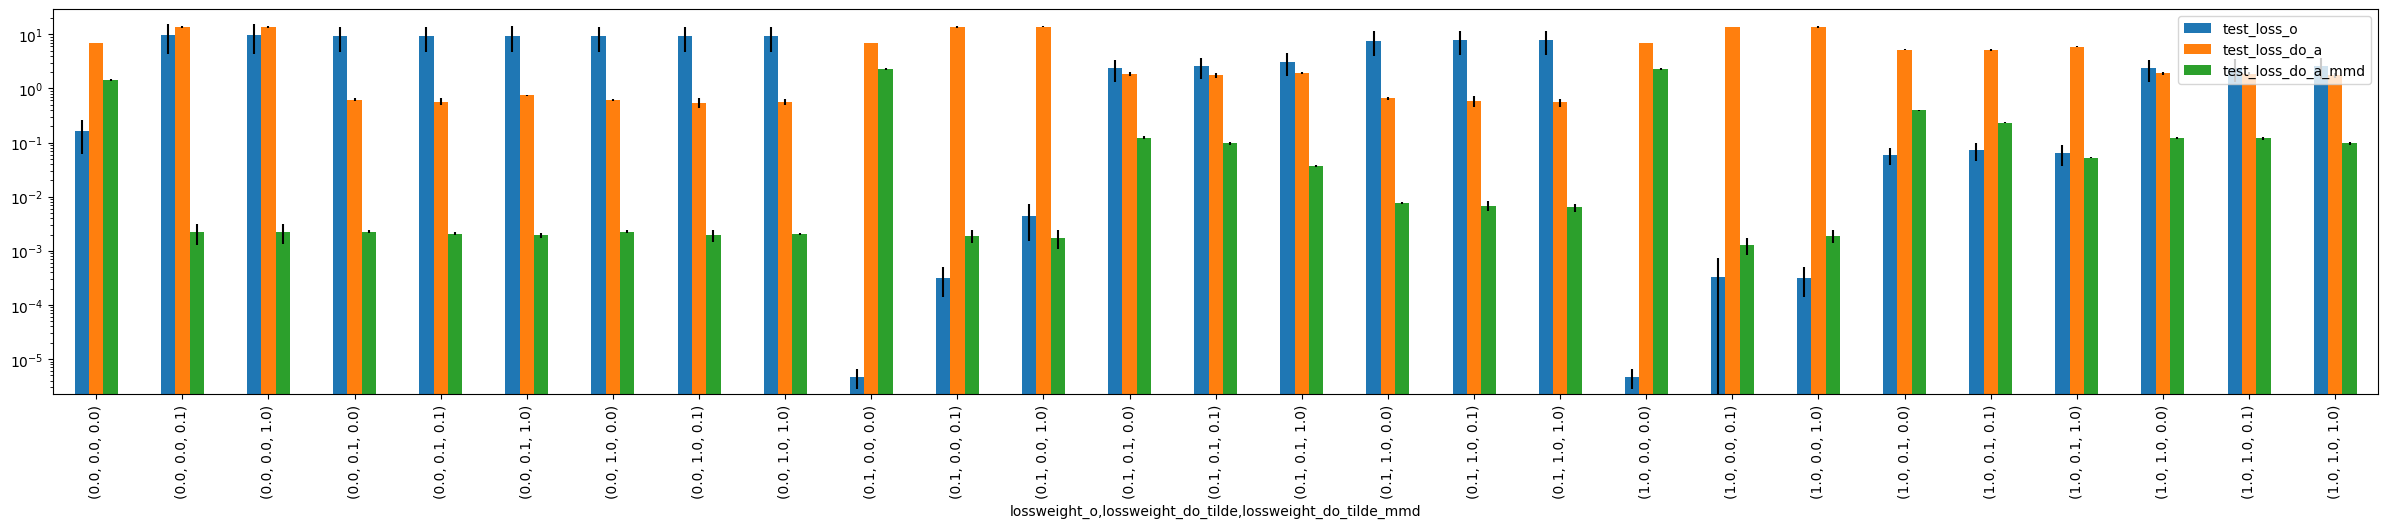

In [23]:
losses_select = ['test_loss_o', 'test_loss_do_a', 'test_loss_do_a_mmd']

d_mean = d.groupby(lws).mean()[losses_select]
d_std = d.groupby(lws).std()[losses_select]

d_mean.plot(kind='bar',yerr=d_std, logy = True, figsize=(30,5))

<Axes: xlabel='lossweight_o,lossweight_do_tilde,lossweight_do_tilde_mmd'>

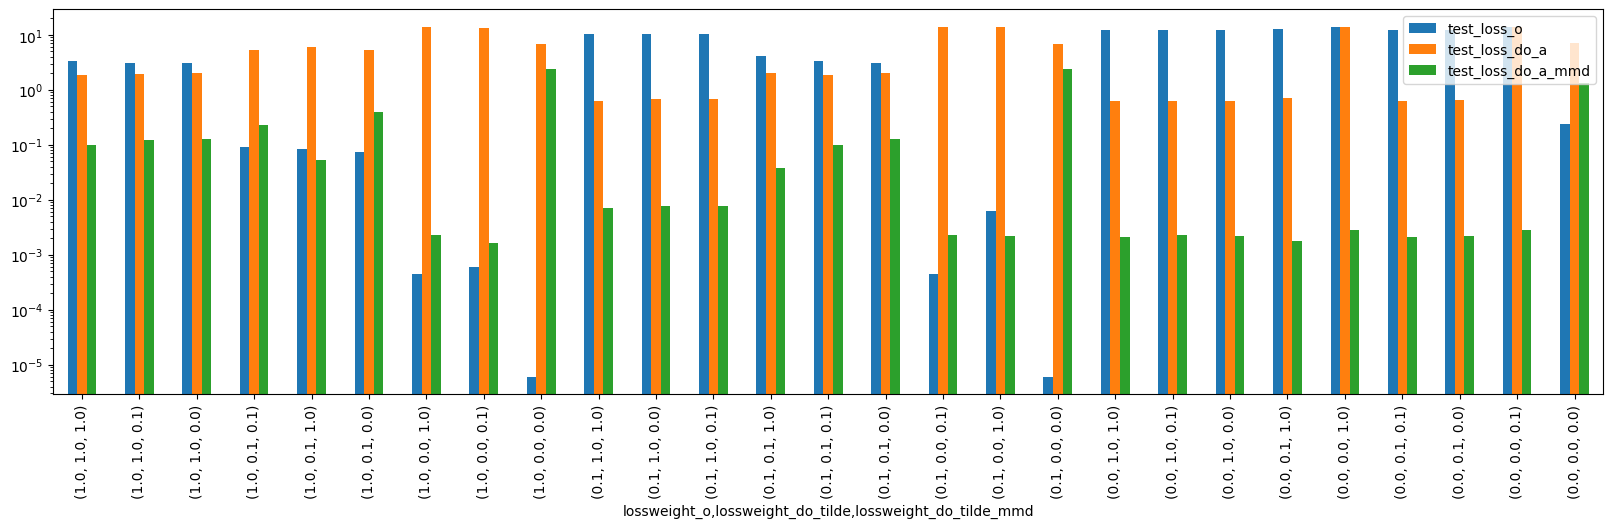

In [29]:
losses_select = ['test_loss_o', 'test_loss_do_a', 'test_loss_do_a_mmd']
d.set_index(lws)[losses_select].plot(kind='bar', logy=True, figsize=(20,5))

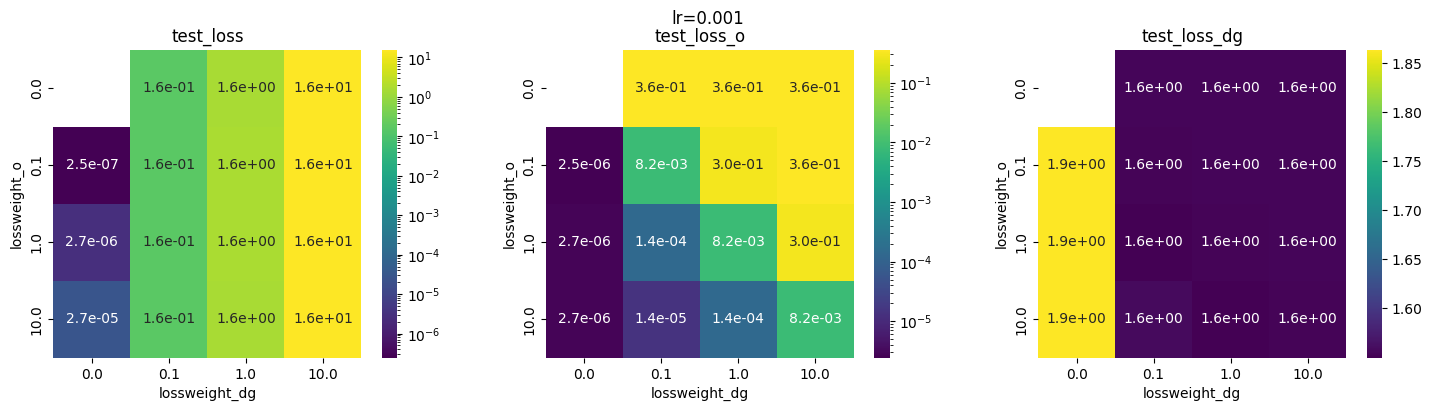

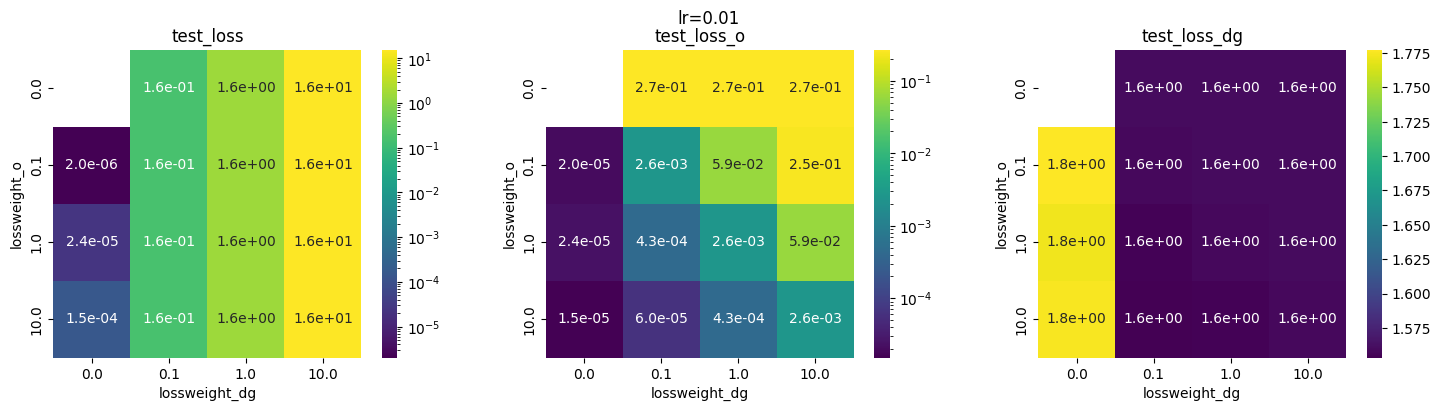

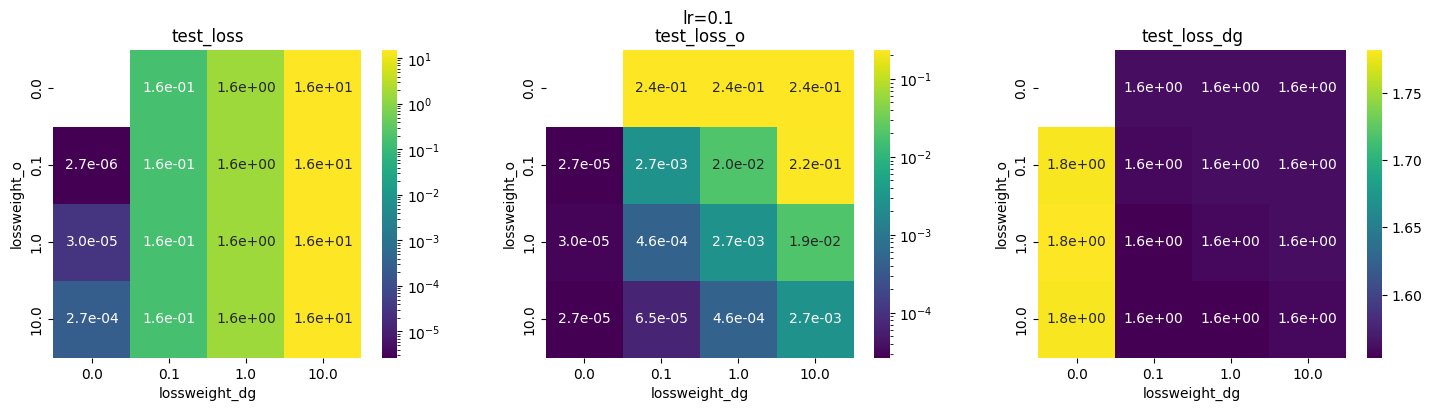

In [20]:
for lr, d_lr in d.groupby('lr'):

    d_lr = d_lr.set_index([lw_o, lw_dg])
    d_lr = d_lr.drop([(0, 0)])

    d_lr.reorder_levels([lw_o, lw_dg]).sort_index()

    d_pivots = {loss: d_lr.pivot_table(index=[lw_o], columns=[lw_dg], values=loss, aggfunc='mean') for loss in losses}

    n_plots = len(d_pivots)

    fig, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 4))
    for i, (loss, d_pivot) in enumerate(d_pivots.items()):
        # plot_pivot(d_pivot, ax=ax[i], title=loss)
        ax = axs[i]

        norm = LogNorm() if loss != 'test_loss_dg' else None
        sns.heatmap(d_pivot, annot=True, fmt=".1e", cmap='viridis', ax = ax, square=True, norm=norm)
        ax.set_title(loss)
    fig.suptitle(f'lr={lr}')
    plt.show()